# Assignment 1 2AMM10 2023-2024

## Group: [Fill in your group name]
### Member 1: [Luca Mainardi]
### Member 2: [Francesco Brescia]
### Member 3: [Matthew Nana]

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


In [196]:
# Variable to enable/disable training
TRAIN_SIAMESE = False
TRAIN_TRIPLET = False

In [12]:
# function for loading the training data:

def load_data(file):
    """
    This function loads the data from the specified pickle file and returns a dictionary with the data
    :param filename: the pickle file
    :return: dict with data -- keys and values differ for the train data and test data for each task.
     Please see the cells with example code below for explanations and examples of the data structure per data set.
    """
    with open(file, 'rb') as f:
        data_dict = pickle.load(f)
    return data_dict

In [13]:
train_data = load_data('data/train_data.pkl')

In [14]:
# the structure of the training data is a dict, where the keys are strings indicating the alphabet.
# The values are again dicts, with the keys being the character and the values being a list of images of that character.

# see the code below for examples of working with the train data

alphabets = list(train_data.keys())


print('example alphabet names:', alphabets[:5])
print('\n')
print('how to get an example image for a specific character:')

alphabet_id = 4
alphabet = alphabets[alphabet_id]  # a dict
characters_for_this_alphabet = list(train_data[alphabet].keys())
character_id = 5
character = characters_for_this_alphabet[character_id]
image_id = 2

print(f'shape of image {image_id} of character {character} of alphabet {alphabet}:', train_data[alphabet][character][image_id].shape)

example alphabet names: ['Alphabet_of_the_Magi', 'Anglo-Saxon_Futhorc', 'Arcadian', 'Armenian', 'Asomtavruli_(Georgian)']


how to get an example image for a specific character:
shape of image 2 of character character06 of alphabet Asomtavruli_(Georgian): torch.Size([1, 105, 105])


In [15]:
len(alphabets)

30

In [16]:
# function for plotting some examples:

def plot_example_data(data_dict):
    """
    This function plots some examples of the data
    :param data_dict: dict with as keys a string specifying the alphabet, and as values a dict with as keys the character of the alphabet, and as values a list om images of the alphabet
    """
    fig, axs = plt.subplots(2, 5, figsize=(15, 6))
    alphabets_to_plot = np.random.choice(list(data_dict.keys()), size=10, replace=False)
    
    for i, alphabet in enumerate(alphabets_to_plot):
        characters = data_dict[alphabet]
        character_to_plot = np.random.choice(list(characters.keys()), size=1)[0]
        images = characters[character_to_plot]
        im_idx = np.random.choice(len(images), size=1)[0]
        axs[i//5, i%5].imshow(images[im_idx].permute(1, 2, 0))
        axs[i//5, i%5].set_title(alphabet + '\n' + character_to_plot, fontsize=8)
        axs[i//5, i%5].axis('off')
    # plt.show()


<Figure size 640x480 with 0 Axes>

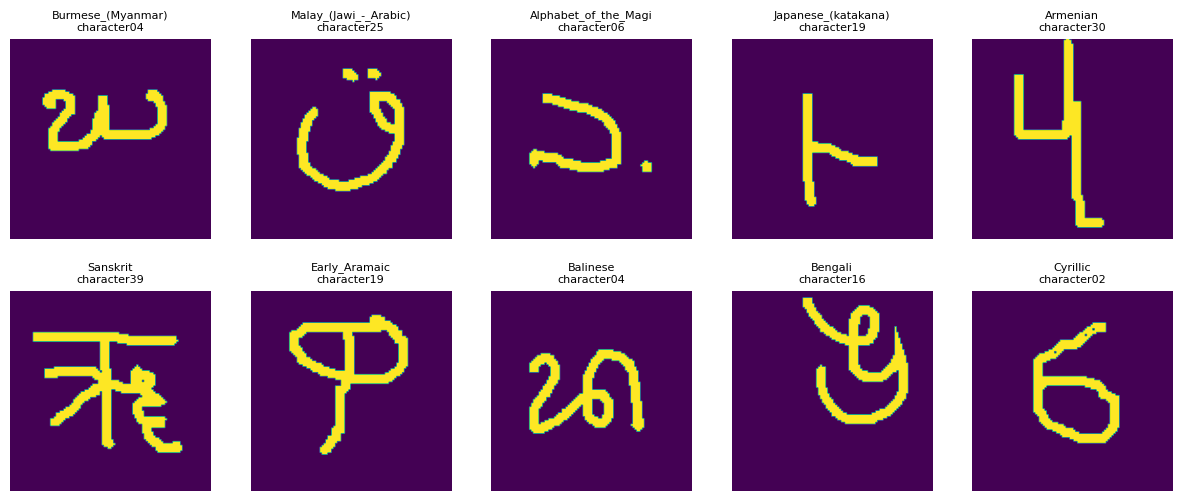

In [17]:
plt.figure()
plot_example_data(train_data)
# plt.savefig('example_data.png', dpi=600)
plt.show()

# Task 1: character recognition

In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from torchvision.models import resnet18
from tqdm import tqdm
from torch.utils.data import random_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score

## Siamese Network

In [19]:
class ContrastiveLoss(nn.Module):
    """
    Contrastive loss function for training siamese networks.
    
    This loss function calculates the contrastive loss between two outputs of a siamese network.
    The contrastive loss encourages the network to minimize the distance between similar pairs
    and maximize the distance between dissimilar pairs.
    
    Args:
        margin (float): The margin value for the contrastive loss. Default is 1.0.
    """
    def __init__(self, margin=1.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        """
        Forward pass of the contrastive loss function.
        
        Args:
            output1 (torch.Tensor): The output of the first branch of the siamese network.
            output2 (torch.Tensor): The output of the second branch of the siamese network.
            label (torch.Tensor): The label indicating whether the pair is similar (0) or dissimilar (1).
        
        Returns:
            torch.Tensor: The contrastive loss value.
        """
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))

        return loss_contrastive

In [197]:

# Siamese Network definition
class SiameseNetwork(nn.Module):
    """
    SiameseNetwork is a class that represents a siamese neural network model.
    It takes two input images and computes their feature embeddings using a shared feature extractor.
    The feature embeddings are then passed through a fully connected layer to obtain the final output.
    """

    def __init__(self, pretrained=True):
        super(SiameseNetwork, self).__init__()
        self.feature_extractor = self.get_feature_extractor(pretrained)
        self.fc = nn.Linear(512, 128)

    def get_feature_extractor(self, pretrained):
        resnet = resnet18(pretrained=pretrained)
        feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        return feature_extractor

    def forward_one(self, x):
        """
        Forward pass for a single input image.
        Computes the feature embedding for the input image using the shared feature extractor.
        
        Args:
            x (torch.Tensor): Input image tensor.
        
        Returns:
            torch.Tensor: Feature embedding tensor.
        """
        return self.feature_extractor(x).squeeze()

    def forward(self, x1, x2):
        """
        Forward pass for a pair of input images.
        Computes the feature embeddings for both input images and returns them as output.
        
        Args:
            x1 (torch.Tensor): First input image tensor.
            x2 (torch.Tensor): Second input image tensor.
        
        Returns:
            Tuple[torch.Tensor, torch.Tensor]: Feature embeddings for both input images.
        """
        output1 = self.forward_one(x1)
        output2 = self.forward_one(x2)
        return output1, output2

class SiameseDataset(Dataset):
    """
    A custom dataset class for creating pairs of images with their corresponding labels.
    
    Args:
        data_dict (dict): A dictionary containing the image data organized by alphabet and character.
        transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed version.
    
    Attributes:
        images (list): A list of all the images in the dataset.
        labels (list): A list of labels corresponding to each image.
        transform (callable): The transform function to be applied to the images.
        encoder (LabelEncoder): An instance of the LabelEncoder class for encoding the labels.
        pairs (list): A list of pairs of images with the same label.
        pairs_labels (list): A list of labels corresponding to each pair of images.
    """
    def __init__(self, data_dict, transform=None):

        np.random.seed(42)
        
        self.images = []
        self.labels = []
        self.transform = transform
        self.encoder = LabelEncoder()

        for alphabet in data_dict.keys():
            characters = data_dict[alphabet]
            for character in characters.keys():
                images = characters[character]
                self.images.extend(images)
                self.labels.extend([f"{alphabet} {character}"] * len(images))

        self.labels = self.encoder.fit_transform(self.labels)

        # Create list with all possible pairs of images with same label
        self.pairs = []
        self.pairs_labels = []
        for i in range(len(self.images)):
            for j in range(i+1, len(self.images)):
                if self.labels[i] == self.labels[j]:
                    self.pairs.append((self.images[i], self.images[j]))
                    self.pairs_labels.append(1)

        # sample the same number of pairs with different labels
        pairs_with_diff_labels = []
        while len(pairs_with_diff_labels) < len(self.pairs):
            i, j = np.random.choice(len(self.images), size=2, replace=False,  )
            if self.labels[i] != self.labels[j]:
                pairs_with_diff_labels.append((self.images[i], self.images[j]))

        self.pairs.extend(pairs_with_diff_labels)
        self.pairs_labels.extend([0] * len(pairs_with_diff_labels))


    def __len__(self):
        """
        Returns the total number of pairs in the dataset.
        """
        return len(self.pairs)

    def __getitem__(self, idx):
        """
        Returns the pair of images and the label corresponding to the pair at the given index.
        """
        img1, img2 = self.pairs[idx]

        img1 = img1.repeat(3, 1, 1)
        img2 = img2.repeat(3, 1, 1)
        label = self.pairs_labels[idx]
        
        if self.transform:
            to_pil = transforms.ToPILImage()
            img1 = to_pil(img1)
            img1 = self.transform(img1)  
            img2 = to_pil(img2)
            img2 = self.transform(img2)

        return img1, img2, label

# Function to create Siamese dataset
def create_siamese_dataset(data_dict, transform=None):
    """
    Creates a Siamese dataset from the given data dictionary.
    """
    return SiameseDataset(data_dict=data_dict, transform=transform)

# Function to train Siamese network
def train_siamese_network(siamese_network, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    """
    Trains a Siamese network using the provided training and validation data loaders.

    The function operates as follows:
    - For each epoch, it iterates over the training DataLoader, computes the contrastive loss for each pair of images, and updates the network's parameters.
    - It computes the training error by calling the `compute_error` function with the network's outputs and the labels.
    - It then iterates over the validation DataLoader and computes the validation loss and error without updating the network's parameters.
    - The function prints the training and validation loss and error for each epoch.

    Parameters:
    siamese_network (nn.Module): The Siamese network to be trained.
    train_loader (DataLoader): The DataLoader for the training data.
    val_loader (DataLoader): The DataLoader for the validation data.
    num_epochs (int, optional): The number of epochs to train the network. Default is 10.
    learning_rate (float, optional): The learning rate for the Adam optimizer. Default is 0.001.

    Returns:
    None
    """
    criterion = ContrastiveLoss()
    optimizer = optim.Adam(siamese_network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        siamese_network.train()

        running_loss = 0.0
        running_error = 0.0
        batch_count = 0

        for img1, img2, label in progress_bar:
            optimizer.zero_grad()
            output1, output2 = siamese_network(img1, img2)
            loss = criterion(output1, output2, label)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            errror = compute_auc_roc_siamese(output1.detach(), output2.detach(), label)
            running_error += errror
            batch_count += 1

            # Update the progress bar with the current loss and error
            progress_bar.set_postfix({"loss": running_loss / batch_count, "auc_roc": running_error / batch_count})


        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Auc_Roc: {running_error/len(train_loader)}")

        # Validation
        progress_bar = tqdm(val_loader, desc=f"Val Epoch {epoch + 1}")
        siamese_network.eval()
        running_val_loss = 0.0
        running_val_error = 0.0
        batch_count = 0

        with torch.no_grad():
            for img1, img2, label in progress_bar:
                output1, output2 = siamese_network(img1, img2)
                val_loss = criterion(output1, output2, label)
                running_val_loss += val_loss.item()
                val_error = compute_auc_roc_siamese(output1.detach(), output2.detach(), label)
                running_val_error += val_error
                batch_count += 1

                # Update the progress bar with the current loss and error
                progress_bar.set_postfix({"val_loss": running_val_loss / batch_count, "val_auc_roc": running_val_error / batch_count})

        print(f"Val Epoch {epoch+1}, Loss: {running_val_loss/len(val_loader)}, Auc_Roc: {running_val_error/len(val_loader)}")


# Function to compute error of the Siamese network
def compute_auc_roc_siamese(output1, output2, label):
    """
    Compute the error of the Siamese network.

    This function takes in the outputs of a Siamese network, `output1` and `output2`, and the corresponding `label`.
    It computes the error by first calculating the Euclidean distance between `output1` and `output2`.
    Then, it converts the distances to similarity scores using the sigmoid function.
    Finally, it computes the AUC-ROC (Area Under the Receiver Operating Characteristic) score using the `roc_auc_score` function.
    
    Parameters:
        output1 (torch.Tensor): The output of the first branch of the Siamese network.
        output2 (torch.Tensor): The output of the second branch of the Siamese network.
        label (torch.Tensor): The ground truth labels for the pair of inputs.
    
    Returns:
        float: The AUC-ROC score representing the error of the Siamese network.
    """
    # Compute the Euclidean distance between output1 and output2
    distance = (output1 - output2).pow(2).sum(1).sqrt()

    # Convert distances to similarity scores
    similarity = torch.sigmoid(-distance)

    # Compute the AUC-ROC
    auc_roc = roc_auc_score(label.detach().cpu().numpy(), similarity.detach().cpu().numpy())

    return auc_roc
    


In [198]:
# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

In [158]:
# Create Siamese network and dataset
# siamese_network = SiameseNetwork(pretrained=True)

# siamese_dataset = create_siamese_dataset(train_data, transform=preprocess)

# # Define the size of the validation set
# val_size = int(0.2 * len(siamese_dataset))  # 20% of the dataset
# train_size = len(siamese_dataset) - val_size

# # Create train and validation sets
# generator = torch.Generator().manual_seed(42)
# siamese_train_dataset, siamese_val_dataset = random_split(siamese_dataset, [train_size, val_size], generator=generator)

# # Create data loaders
# train_loader = DataLoader(siamese_train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(siamese_val_dataset, batch_size=32, shuffle=False)

# print(f"Num of training pairs: {len(siamese_train_dataset)}")
# print(f"Num of validation pairs: {len(siamese_val_dataset)}")

/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Num of training pairs: 293056
Num of validation pairs: 73264


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '0')

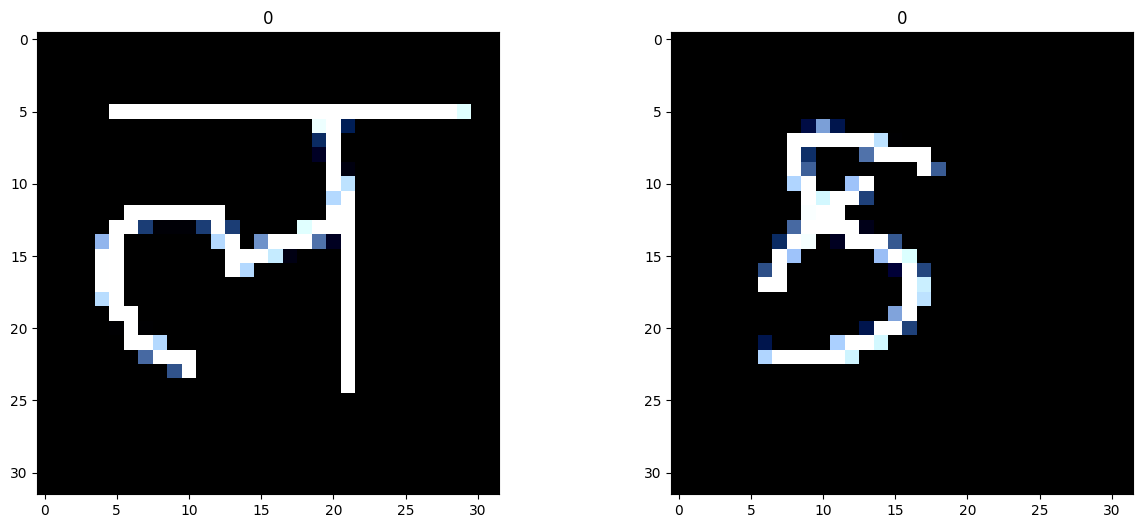

In [159]:
# Plot some random pairs of images from the dataset with their labels
plt.figure(figsize=(15, 6))

random_idx = np.random.choice(len(siamese_dataset))
img1, img2, label = siamese_dataset[random_idx]
plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.title(label)
plt.subplot(1, 2, 2)
plt.imshow(img2.permute(1, 2, 0))
plt.title(label)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Text(0.5, 1.0, '1')

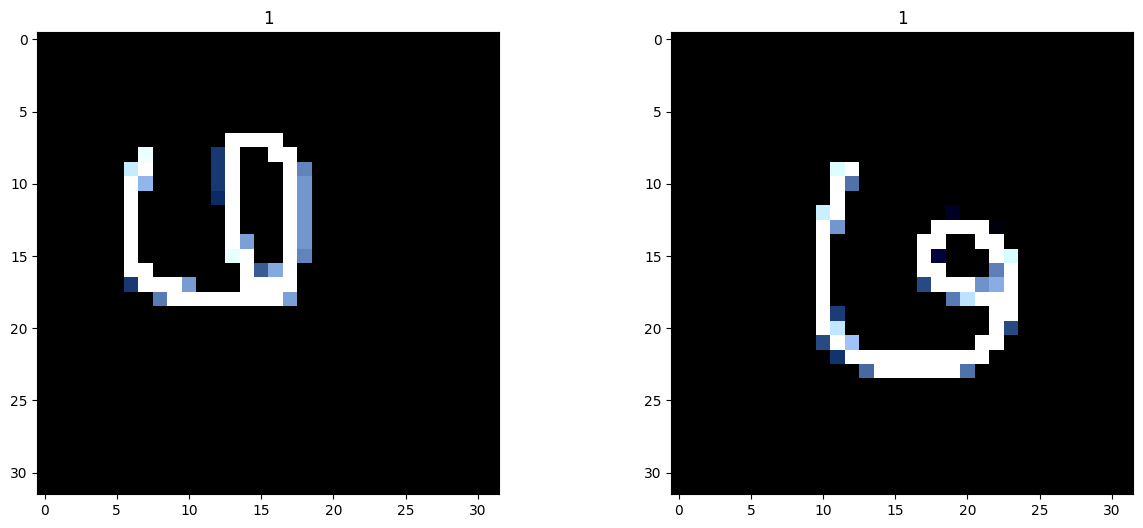

In [160]:
# Plot some images with label == 1
plt.figure(figsize=(15, 6))

random_idx = np.random.choice(np.where(np.array(siamese_dataset.pairs_labels) == 1)[0])
img1, img2, label = siamese_dataset[random_idx]
plt.subplot(1, 2, 1)
plt.imshow(img1.permute(1, 2, 0))
plt.title(label)
plt.subplot(1, 2, 2)
plt.imshow(img2.permute(1, 2, 0))
plt.title(label)


In [161]:
# Train the Siamese network
if TRAIN_SIAMESE:
    train_siamese_network(siamese_network, train_loader, val_loader, num_epochs=1, learning_rate=0.01)
    # Save the trained Siamese network
    torch.save(siamese_network.state_dict(), 'siamese_network.pth')

In [22]:
# Load the trained Siamese network
siamese_network = SiameseNetwork()
siamese_network.load_state_dict(torch.load('siamese_network.pth'))

/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/lucamainardi/.pyenv/versions/3.11.0/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


<All keys matched successfully>

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


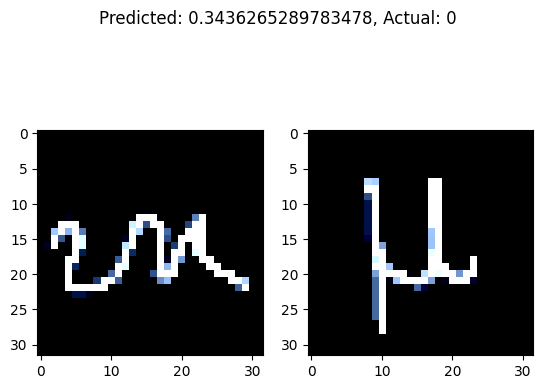

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


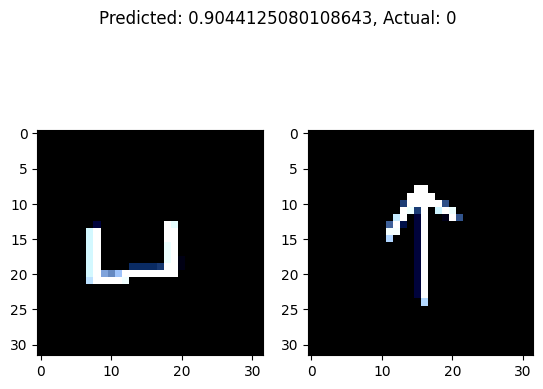

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


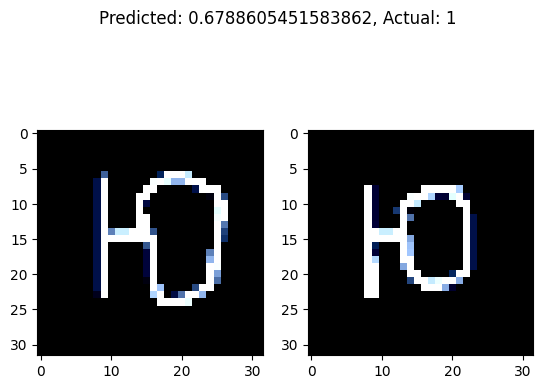

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


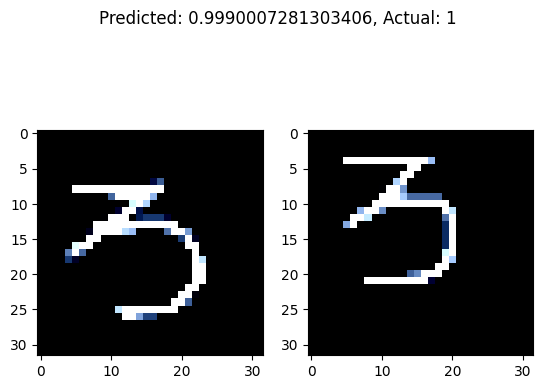

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


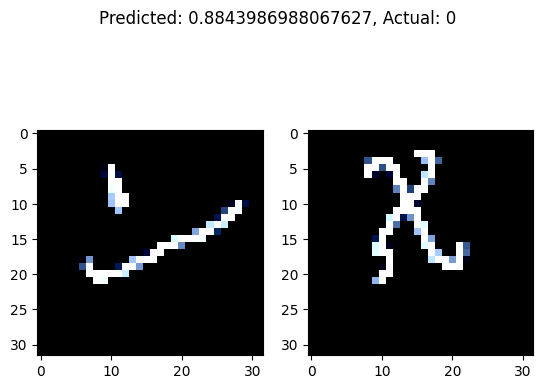

In [163]:
import matplotlib.pyplot as plt
import random
import itertools

# Test the trained Siamese network on some random pairs of images
def visualize_predictions(siamese_network, val_loader, num_pairs=5):
    siamese_network.eval()
    for i in range(num_pairs):
        # Create a new iterator for the validation loader
        dataiter = iter(val_loader)
        # Select a random batch
        batch_idx = random.randint(0, len(val_loader)-1)
        # Reset the iterator and advance to the random batch
        dataiter = itertools.islice(dataiter, batch_idx, None)
        img1, img2, label = next(dataiter)

        output1, output2 = siamese_network(img1, img2)
        cosine_similarity = nn.functional.cosine_similarity(output1, output2)
        predicted_label = cosine_similarity
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.imshow(img1[0].numpy().transpose((1, 2, 0)))
        ax2.imshow(img2[0].numpy().transpose((1, 2, 0)))
        fig.suptitle(f"Predicted: {predicted_label[0]}, Actual: {label[0].item()}")
        plt.show()

visualize_predictions(siamese_network, val_loader)


In [164]:
def evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=1) -> float:
    """
    This function evaluates the Siamese network on the test data
    :param siamese_network: the trained Siamese network
    :param data_dict_test: the test data dictionary with the keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'
    :param K: the number of most similar images to consider
    """
    siamese_network.eval()
    correct_predictions = 0   
    num_images = 0

    # Transform images
    toPILImage = transforms.ToPILImage()

    for alphabet in data_dict_test['annotated_images'].keys():

        correct_predictions_alphabet = 0

        for i, unseen_image in enumerate(data_dict_test['unseen_images'][alphabet]):
            
            # list of cosine similarities
            cosine_similarities = []

            unseen_image = unseen_image.repeat(3, 1, 1)
            unseen_image = toPILImage(unseen_image)
            unseen_image = preprocess(unseen_image)

            for j, annotated_image in enumerate(data_dict_test['annotated_images'][alphabet]):

                # Convert the images to PIL images
                annotated_image = annotated_image.repeat(3, 1, 1)
                annotated_image = toPILImage(annotated_image)
                annotated_image = preprocess(annotated_image)

                # Compute the embeddings for the images
                output1, output2 = siamese_network(annotated_image.unsqueeze(0), unseen_image.unsqueeze(0))
                # Compute the cosine similarity between the embeddings
                cosine_similarity = nn.functional.cosine_similarity(output1, output2, dim=0)
                # Add the cosine similarity to the list
                cosine_similarities.append(cosine_similarity.item())
            
                # Print the cosine similarity between the annotated and unseen images
                # print(f"Cosine similarity between unseen_image {i} and annotated_image {j} : {cosine_similarity}")
            
            # Get the indices of the K most similar images
            most_similar_indices = np.argsort(cosine_similarities)[-K:]
            # Get the corresponding labels
            most_similar_labels = [data_dict_test['annotated_images_labels'][alphabet][idx] for idx in most_similar_indices]
            # Get the actual label of the unseen image
            actual_label = data_dict_test['unseen_images_labels'][alphabet][i]
            # Print the most similar labels and the actual label
            # print(f"Most similar labels: {most_similar_labels}")
            # print(f"Actual label: {actual_label}")
            # Check if the actual label is in the most similar labels
            if actual_label in most_similar_labels:
                correct_predictions += 1
                correct_predictions_alphabet += 1
            num_images += 1

        accuracy_alphabet = correct_predictions_alphabet / len(data_dict_test['unseen_images'][alphabet])
        print(f"Accuracy for alphabet {alphabet}: {accuracy_alphabet}")

    # Compute the accuracy
    accuracy = correct_predictions / num_images
    return accuracy

## Triplet Network

In [199]:
class TripletLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(TripletLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, output3):
        positive_distance = (output1 - output2).pow(2).sum(1)
        negative_distance = (output1 - output3).pow(2).sum(1)
        losses = torch.relu(positive_distance - negative_distance + self.margin)
        return losses.mean()

In [200]:
class Lambda(nn.Module):
    """
    A utility class that allows you to create a PyTorch nn.Module from an arbitrary function.
    """
    def __init__(self, func):
        super().__init__()
        self.func = func

    def forward(self, x):
        return self.func(x)


class EmbeddingNet(nn.Module):
    """
    A PyTorch implementation of a Convolutional Neural Network (CNN) for feature extraction or embedding. 

    The network consists of three convolutional blocks each followed by a batch normalization, ReLU activation, and max pooling. 
    After the convolutional blocks, the tensor is flattened and passed through two fully connected (linear) layers. 

    The final output is a 10-dimensional vector which can be used as an embedding of the input.
    """
    def __init__(self):
        super(EmbeddingNet, self).__init__()

        self.front_layer = nn.Sequential(
            # Conv Layer block 1
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            # Conv Layer block 2
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),


            # Conv Layer block 3
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),

            Lambda(lambda x: x.view(x.size(0), -1)),

            nn.Linear(4096, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
        )

        self.last_layer = nn.Linear(512, 10)

    def forward(self, x):
        """Perform forward."""
        # conv layers
        x = self.front_layer(x)
        x = self.last_layer(x)
        return x

    def get_embedding(self, x):
        return self.forward(x)

class TripletNet(nn.Module):
    """
    A PyTorch implementation of a Triplet Network for learning useful data embeddings. 

    The network takes three inputs - an anchor, a positive of the same class as the anchor, and a negative of a different class. 
    Each of these inputs is passed through the same embedding network, and the output embeddings are returned.

    The goal during training is to learn an embedding such that the distance between the anchor and positive is less than the distance between the anchor and negative.
    """
    def __init__(self, embedding_net):
        """Initializes the TripletNet with the given embedding network."""
        super(TripletNet, self).__init__()
        self.embedding_net = embedding_net

    def forward(self, x1, x2, x3):
        """Forward pass for the TripletNet."""
        output1 = self.embedding_net(x1)
        output2 = self.embedding_net(x2)
        output3 = self.embedding_net(x3)
        return output1, output2, output3

    def get_embedding(self, x):
        """Returns the embeddings of the input."""
        return self.embedding_net(x)
    

class TripletDataset(Dataset):
    """
    A custom dataset class for creating triplets of images with their corresponding labels.
    
    Args:
        data_dict (dict): A dictionary containing the image data organized by alphabet and character.
        transform (callable, optional): A function/transform that takes in an PIL image and returns a transformed version.
    
    Attributes:
        images (list): A list of all the images in the dataset.
        labels (list): A list of labels corresponding to each image.
        transform (callable): The transform function to be applied to the images.
        encoder (LabelEncoder): An instance of the LabelEncoder class for encoding the labels.
        triplets (list): A list of triplets of images with the anchor, positive and negative images.
    """
    def __init__(self, data_dict, transform=None):

        np.random.seed(42)
        
        self.images = []
        self.labels = []
        self.transform = transform
        self.encoder = LabelEncoder()

        for alphabet in data_dict.keys():
            characters = data_dict[alphabet]
            for character in characters.keys():
                images = characters[character]
                self.images.extend(images)
                self.labels.extend([f"{alphabet} {character}"] * len(images))

        self.labels = self.encoder.fit_transform(self.labels)

        # Create list with triplets of images, where the first two images are similar and the third is different
        # Consider all the pairs of positive images and sample two negative images for each pair
        self.triplets = []

        for i in tqdm(range(len(self.images))):
            for j in range(i+1, len(self.images)):
                if self.labels[i] == self.labels[j]:
                    for _ in range(2):
                        # sample the third image
                        index = np.random.choice(len(self.images))
                        # If the third image is from the same class, sample another one
                        while self.labels[index] == self.labels[i]:
                            index = np.random.choice(len(self.images))
                        self.triplets.append((self.images[i], self.images[j], self.images[index]))



    def __len__(self):
        """
        Returns the total number of triplets in the dataset.
        """
        return len(self.triplets)

    def __getitem__(self, idx):
        """
        Returns the triplet of images at the given index.
        """
        img1, img2, img3 = self.triplets[idx]

        
        if self.transform:
            to_pil = transforms.ToPILImage()
            img1 = to_pil(img1)
            img1 = self.transform(img1)  
            img2 = to_pil(img2)
            img2 = self.transform(img2)
            img3 = to_pil(img3)
            img3 = self.transform(img3)

        return img1, img2, img3
    
# Function to create Triplet dataset
def create_triplet_dataset(data_dict, transform=None):
    """
    Creates a Triplet dataset from the given data dictionary.
    """
    return TripletDataset(data_dict=data_dict, transform=transform)

# Function to train Triplet network
def train_triplet_network(triplet_network, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    """
    Trains a triplet network for a specified number of epochs.

    The function takes as input a triplet network, training and validation data loaders, number of epochs, and learning rate.
    It uses the Adam optimizer and a custom TripletLoss criterion.
    For each epoch, it iterates over the training data, computes the loss and backpropagates the gradients.
    It also computes the AUC-ROC for each batch and keeps a running total.
    After each epoch, it evaluates the network on the validation data and computes the average loss and AUC-ROC.

    Parameters:
    triplet_network (nn.Module): The triplet network to train.
    train_loader (DataLoader): The DataLoader for the training data.
    val_loader (DataLoader): The DataLoader for the validation data.
    num_epochs (int, optional): The number of epochs to train for. Default is 10.
    learning_rate (float, optional): The learning rate for the Adam optimizer. Default is 0.001.

    Returns:
    None
    """
    criterion = TripletLoss()
    optimizer = optim.Adam(triplet_network.parameters(), lr=learning_rate)

    for epoch in range(num_epochs):
        # Training
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")

        triplet_network.train()

        running_loss = 0.0
        running_auc_roc = 0.0
        batch_count = 0

        for img1, img2, img3 in progress_bar:
            optimizer.zero_grad()
            output1, output2, output3 = triplet_network(img1, img2, img3)
            loss = criterion(output1, output2, output3)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            auc_roc = compute_auc_roc_triplet(output1.detach(), output2.detach(), output3.detach())
            running_auc_roc += auc_roc
            batch_count += 1

            # Update the progress bar with the current loss and auc_roc
            progress_bar.set_postfix({"loss": running_loss / batch_count, "auc_roc": running_auc_roc / batch_count})

        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader)}, Auc_Roc: {running_auc_roc/len(train_loader)}")

        # Validation
        progress_bar = tqdm(val_loader, desc=f"Val Epoch {epoch + 1}")
        triplet_network.eval()
        running_val_loss = 0.0
        running_val_auc_roc = 0.0
        batch_count = 0

        with torch.no_grad():
            for img1, img2, img3 in progress_bar:
                output1, output2, output3 = triplet_network(img1, img2, img3)
                val_loss = criterion(output1, output2, output3)
                running_val_loss += val_loss.item()
                val_auc_roc = compute_auc_roc_triplet(output1.detach(), output2.detach(), output3.detach())
                running_val_auc_roc += val_auc_roc
                batch_count += 1

                # Update the progress bar with the current loss and auc_roc
                progress_bar.set_postfix({"val_loss": running_val_loss / batch_count, "val_auc_roc": running_val_auc_roc / batch_count})

        print(f"Val Epoch {epoch+1}, Loss: {running_val_loss/len(val_loader)}, Auc_Roc: {running_val_auc_roc/len(val_loader)}")


# Function to compute auc_roc of the Triplet network
def compute_auc_roc_triplet(output1, output2, output3):
    """
    Computes the Area Under the Receiver Operating Characteristic (AUC-ROC) for a triplet network.

    The function takes as input the output embeddings of an anchor, positive, and negative example from a triplet network.
    It computes the Euclidean distance between the anchor and positive examples (distance_positive) and between the anchor and negative examples (distance_negative).
    These distances are then converted to similarity scores using the sigmoid function.
    The AUC-ROC is computed using these similarity scores as predicted probabilities and true labels (1 for positive pairs, 0 for negative pairs).

    Parameters:
    output1 (torch.Tensor): The output embedding of the anchor example.
    output2 (torch.Tensor): The output embedding of the positive example.
    output3 (torch.Tensor): The output embedding of the negative example.

    Returns:
    float: The AUC-ROC score.
    """
    # Compute the Euclidean distance between output1 and output2 and between output1 and output3
    distance_positive = (output1 - output2).pow(2).sum(1).sqrt()
    distance_negative = (output1 - output3).pow(2).sum(1).sqrt()

    # Convert distances to similarity scores
    similarity_positive = torch.sigmoid(-distance_positive)
    similarity_negative = torch.sigmoid(-distance_negative)

    # Concatenate the similarity scores and convert to numpy
    scores = torch.cat((similarity_positive, similarity_negative)).cpu().detach().numpy()

    # Create true labels: 1 for positive pairs, 0 for negative pairs
    labels = np.concatenate((np.ones(similarity_positive.shape[0]), np.zeros(similarity_negative.shape[0])))

    # Compute the AUC-ROC
    auc_roc = roc_auc_score(labels, scores)

    return auc_roc

    # error = 1 - similarity_positive + similarity_negative

    # return error.mean()
    # return auc_roc

In [201]:
# Define preprocessing steps
preprocess = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0], std=[1]),
    transforms.Grayscale(num_output_channels=1)
])

In [202]:
# Create Triplet network
triplet_network = TripletNet(EmbeddingNet())

In [160]:
#  Create Triplet dataset
triplet_dataset = create_triplet_dataset(train_data, transform=preprocess)

# Define the size of the validation set
val_size = int(0.2 * len(triplet_dataset))  # 20% of the dataset
train_size = len(triplet_dataset) - val_size

# Create train and validation sets
generator = torch.Generator().manual_seed(42)
triplet_train_dataset, triplet_val_dataset = random_split(triplet_dataset, [train_size, val_size], generator=generator)

# Create data loaders
train_loader = DataLoader(triplet_train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(triplet_val_dataset, batch_size=32, shuffle=False)

print(f"Num of training triplets: {len(triplet_train_dataset)}")
print(f"Num of validation triplets: {len(triplet_val_dataset)}")

100%|██████████| 19280/19280 [00:21<00:00, 892.78it/s] 

Num of training triplets: 293056
Num of validation triplets: 73264


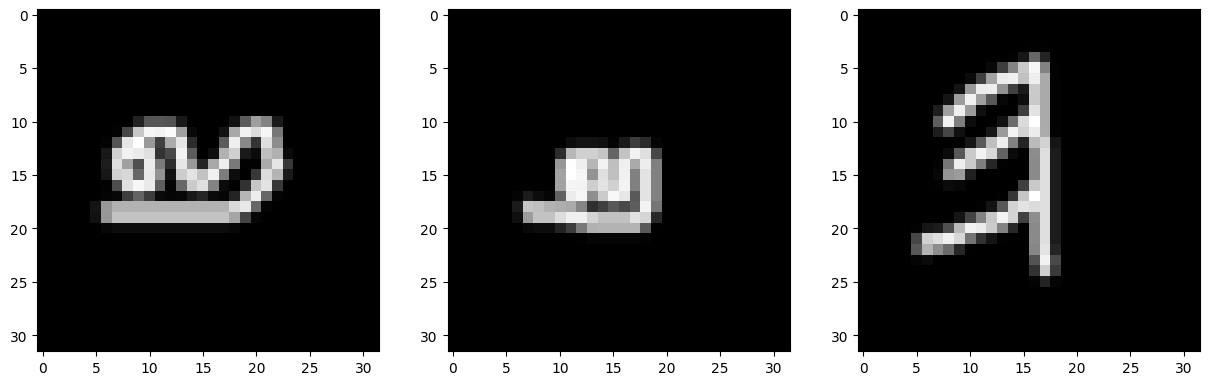

In [203]:
def plot_image(img):
    if img.shape[0] == 1:
        # Grayscale image
        plt.imshow(img.squeeze(0), cmap='gray')
    else:
        # RGB image
        plt.imshow(img.permute(1, 2, 0))

# Plot some random pairs of images from the validation set
plt.figure(figsize=(15, 6))

random_idx = np.random.choice(len(triplet_val_dataset))
img1, img2, img3 = triplet_val_dataset[random_idx]
plt.subplot(1, 3, 1)
plot_image(img1)
plt.subplot(1, 3, 2)
plot_image(img2)
plt.subplot(1, 3, 3)
plot_image(img3)

In [204]:
# Train the Triplet network
if TRAIN_TRIPLET:
    train_triplet_network(triplet_network, train_loader, val_loader, num_epochs=5, learning_rate=0.005)
    # Save the trained Siamese network
    torch.save(triplet_network.state_dict(), 'triplet_network.pth')

Epoch 1:   1%|          | 108/9158 [00:53<1:14:21,  2.03it/s, loss=0.845, auc_roc=0.797]


KeyboardInterrupt: 

In [205]:
# Load the trained Triplet Network
triplet_networks = TripletNet(EmbeddingNet())
triplet_networks.load_state_dict(torch.load('triplet_network.pth'))

<All keys matched successfully>

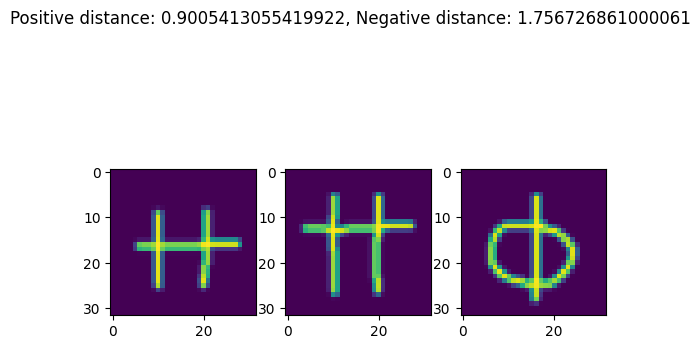

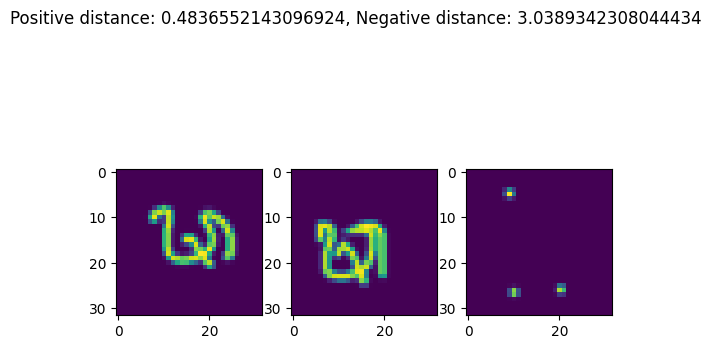

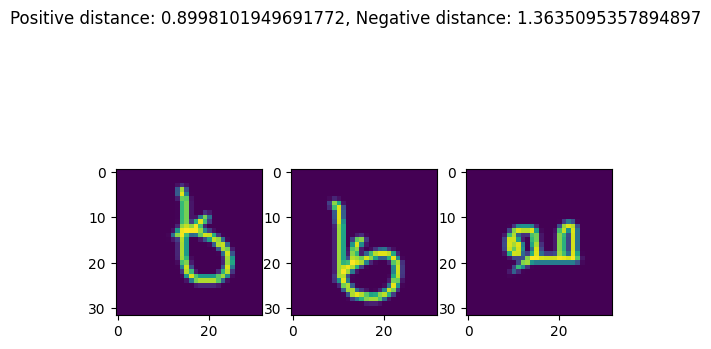

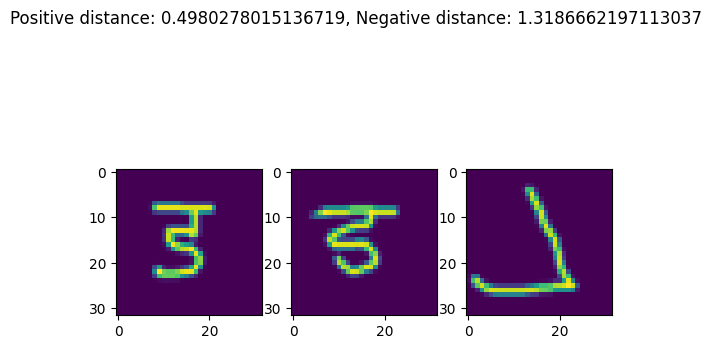

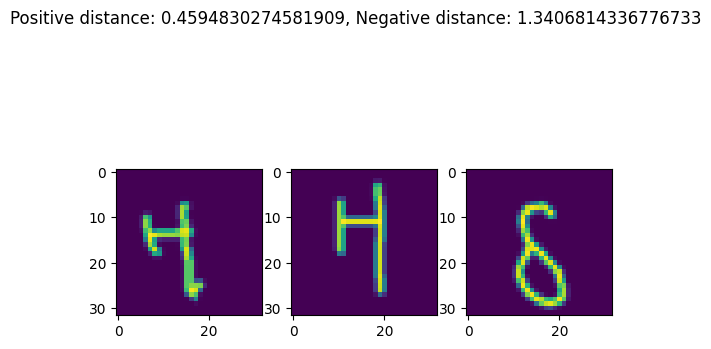

In [206]:
# Visualize predictions
import matplotlib.pyplot as plt
import random
import itertools

# Test the trained Siamese network on some random pairs of images
def visualize_predictions_triplet_network(triplet_network, val_loader, num_pairs=5):
    triplet_network.eval()
    for _ in range(num_pairs):
        # Create a new iterator for the validation loader
        dataiter = iter(val_loader)
        # Select a random batch
        batch_idx = random.randint(0, len(val_loader)-1)
        # Reset the iterator and advance to the random batch
        dataiter = itertools.islice(dataiter, batch_idx, None)
        img1, img2, img3 = next(dataiter)

        output1, output2, output3 = triplet_network(img1, img2, img3)

        distance_positive = (output1 - output2).pow(2).sum(1).sqrt()
        distance_negative = (output1 - output3).pow(2).sum(1).sqrt()
        

        fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
        ax1.imshow(img1[0].numpy().transpose((1, 2, 0)))
        ax2.imshow(img2[0].numpy().transpose((1, 2, 0)))
        ax3.imshow(img3[0].numpy().transpose((1, 2, 0)))
        fig.suptitle(f"Positive distance: {distance_positive[0]}, Negative distance: {distance_negative[0]}")
        plt.show()

visualize_predictions_triplet_network(triplet_network, val_loader)
    


In [218]:
# evaluation method
def evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=1, print_alphabet_accuracy=True) -> float:
    """
    This function evaluates the Triplet network on the test data
    :param triplet_network: the trained Triplet network
    :param data_dict_test: the test data dictionary with the keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'
    :param K: the number of most similar images to consider
    """
    triplet_network.eval()
    correct_predictions = 0   
    num_images = 0

    # Transform images
    toPILImage = transforms.ToPILImage()

    for alphabet in tqdm(data_dict_test['annotated_images'].keys()):

        correct_predictions_alphabet = 0

        for i, unseen_image in enumerate(data_dict_test['unseen_images'][alphabet]):

            # compute embedding for unseen image
            unseen_image = toPILImage(unseen_image)
            unseen_image = preprocess(unseen_image)
            embedding_unseen = triplet_network.get_embedding(unseen_image.unsqueeze(0))
            
            # list of cosine similarities
            distances = []

            for j, annotated_image in enumerate(data_dict_test['annotated_images'][alphabet]):

                # Convert the images to PIL images
                annotated_image = toPILImage(annotated_image)
                annotated_image = preprocess(annotated_image)
                embedding_unnnotated = triplet_network.get_embedding(annotated_image.unsqueeze(0))

                distance = (embedding_unseen - embedding_unnnotated).pow(2).sum(1).sqrt()
                distances.append(distance.item())

            # Get the indices of the K smallest distances
            #print(f"distances: {distances}")
            most_similar_indices = np.argsort(distances)[:K]
            #print(f"most similar indices: {most_similar_indices}")
            # Get the corresponding labels
            most_similar_labels = [data_dict_test['annotated_images_labels'][alphabet][idx] for idx in most_similar_indices]
            #print(f"most similar labels: {most_similar_labels}")

            # Get the actual label of the unseen image
            actual_label = data_dict_test['unseen_images_labels'][alphabet][i]
            #print(f"actual label: {actual_label}")

            if actual_label in most_similar_labels:
                correct_predictions += 1
                correct_predictions_alphabet += 1
            num_images += 1

        accuracy_alphabet = correct_predictions_alphabet / len(data_dict_test['unseen_images'][alphabet])
        if print_alphabet_accuracy:
            print(f"Accuracy for alphabet {alphabet}: {accuracy_alphabet}")

    # Compute the accuracy
    accuracy = correct_predictions / num_images
    return accuracy


## Testing

In [222]:
# load the test data:

data_dict_test = load_data('data/test_data_task1.pkl')
# keys are 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'.
# These keys correspond to the annotated images with known labels for each test alphabet (the sets A);
# labels of the images with known labels for each test alphabet;
# to-be-labeled unseen images for each test alphabet (sets U);
# and labels of the to-be-labeled unseen images for each alphabet, respectively.
# For each alphabet, the labels of the unseen images should be predicted by the model.
# The true labels of the unseen images can only be used to calculate evaluation metrics.
print(data_dict_test.keys())


dict_keys(['annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels'])


In [223]:
# example: let's get some annotated images and their labels for an alphabet in the test data:

alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} annotated images:', alphabet_annotated.shape)

alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} annotated labels:', len(alphabet_annotated_labels))  # equals num_images

alphabet_unseen = data_dict_test['unseen_images'][alphabet]  # a tensor of shape (num_images, 1, height, width)
print(f'Shape of {alphabet} unseen images:', alphabet_unseen.shape)

alphabet_unseen_labels = data_dict_test['unseen_images_labels'][alphabet]  # a list of length num_images
print(f'Number of {alphabet} unseen labels: {len(alphabet_unseen_labels)}. Use the unseen labels only for evaluating your model!')  # equals num_images

Shape of Avesta annotated images: torch.Size([26, 1, 105, 105])
Number of Avesta annotated labels: 26
Shape of Avesta unseen images: torch.Size([494, 1, 105, 105])
Number of Avesta unseen labels: 494. Use the unseen labels only for evaluating your model!


In [224]:
num_classes_test = len(set(alphabet_annotated_labels))
num_classes_test

26

In [225]:
alphabet_annotated.shape

torch.Size([26, 1, 105, 105])

### Evaluate Triplet Network

In [227]:
print_alphabet_accuracy = True
accuracy_1 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=1, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_2 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=2, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_4 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=4, print_alphabet_accuracy=print_alphabet_accuracy)
accuracy_8 = evaluate_triplet_network(triplet_network, data_dict_test, preprocess, K=8, print_alphabet_accuracy=print_alphabet_accuracy)


  5%|▌         | 1/20 [00:18<05:49, 18.41s/it]

Accuracy for alphabet Angelic: 0.3026315789473684


 10%|█         | 2/20 [00:47<07:20, 24.45s/it]

Accuracy for alphabet Atemayar_Qelisayer: 0.22672064777327935


 15%|█▌        | 3/20 [01:19<08:00, 28.28s/it]

Accuracy for alphabet Atlantean: 0.12753036437246965


 20%|██        | 4/20 [01:51<07:52, 29.53s/it]

Accuracy for alphabet Aurek-Besh: 0.32388663967611336


 25%|██▌       | 5/20 [02:22<07:29, 29.96s/it]

Accuracy for alphabet Avesta: 0.2611336032388664


 30%|███       | 6/20 [02:55<07:18, 31.30s/it]

Accuracy for alphabet Ge_ez: 0.20647773279352227


 35%|███▌      | 7/20 [04:32<11:24, 52.63s/it]

Accuracy for alphabet Glagolitic: 0.15087719298245614


 40%|████      | 8/20 [06:01<12:52, 64.35s/it]

Accuracy for alphabet Gurmukhi: 0.10292397660818714


 45%|████▌     | 9/20 [07:17<12:26, 67.89s/it]

Accuracy for alphabet Kannada: 0.09114249037227215


 50%|█████     | 10/20 [07:48<09:24, 56.48s/it]

Accuracy for alphabet Keble: 0.3340080971659919


 55%|█████▌    | 11/20 [09:29<10:29, 69.97s/it]

Accuracy for alphabet Malayalam: 0.1455767077267637


 60%|██████    | 12/20 [10:44<09:33, 71.66s/it]

Accuracy for alphabet Manipuri: 0.08157894736842106


 65%|██████▌   | 13/20 [11:27<07:19, 62.85s/it]

Accuracy for alphabet Mongolian: 0.11403508771929824


 70%|███████   | 14/20 [12:54<07:00, 70.10s/it]

Accuracy for alphabet Old_Church_Slavonic_(Cyrillic): 0.22105263157894736


 70%|███████   | 14/20 [14:10<06:04, 60.72s/it]


KeyboardInterrupt: 

In [195]:
print(f"Accuracy 1: {accuracy_1}")
print(f"Accuracy 2: {accuracy_2}")
print(f"Accuracy 4: {accuracy_4}")
print(f"Accuracy 8: {accuracy_8}")

Accuracy@2: 0.6723903841546203
Accuracy@4: 0.8157495407715039
Accuracy@8: 0.9234885392540532


Number of images in alphabet Keble: 26


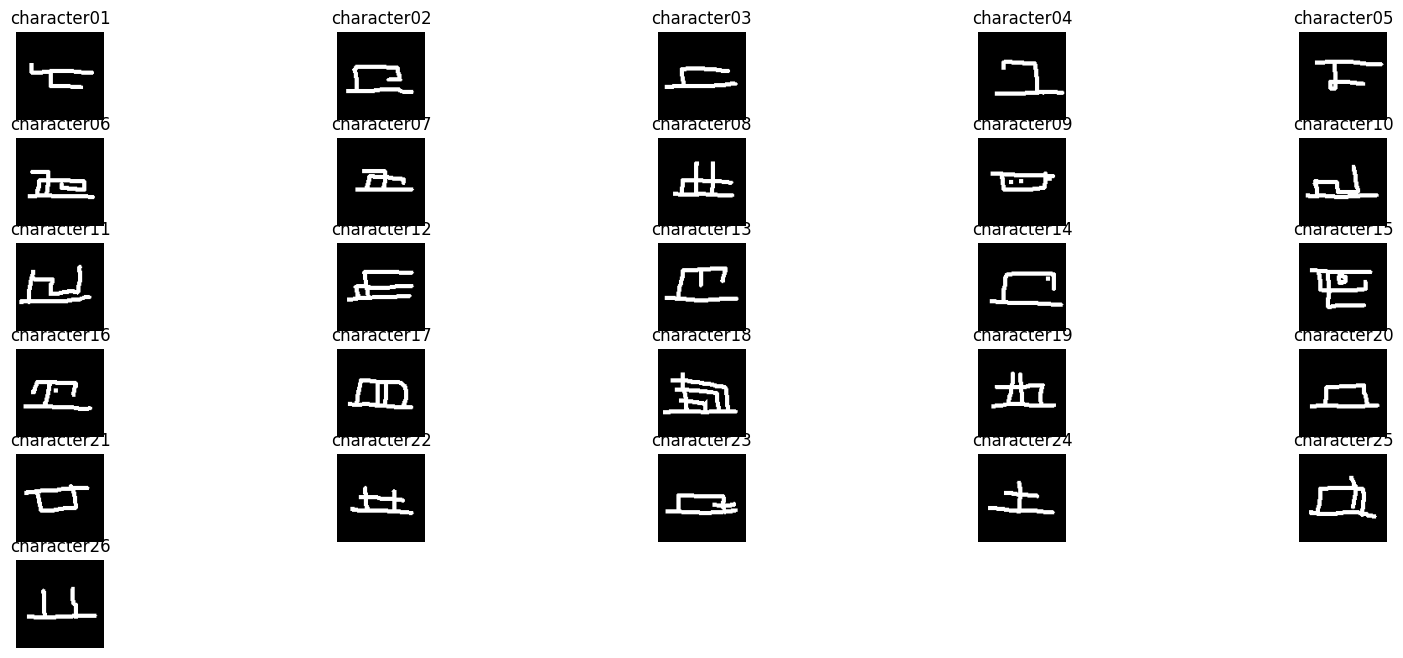

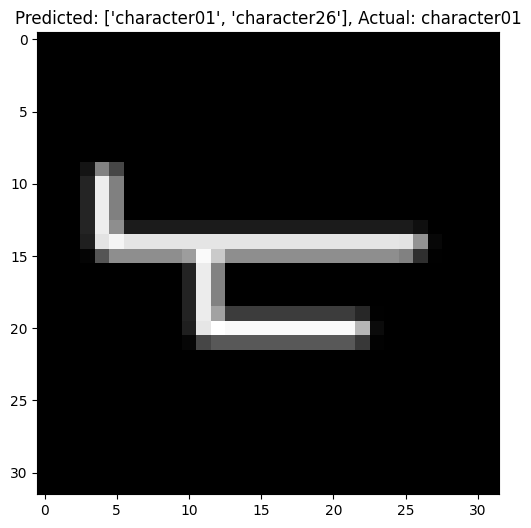

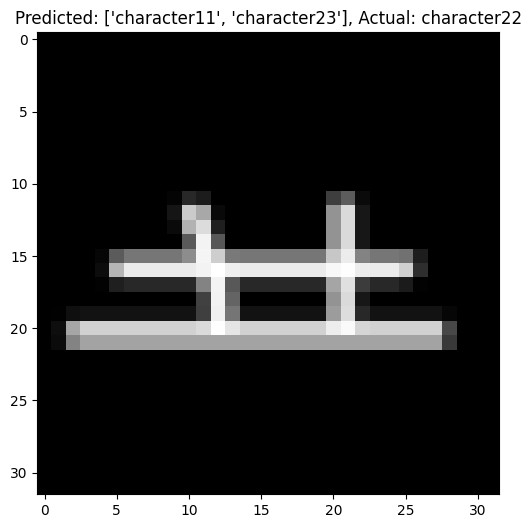

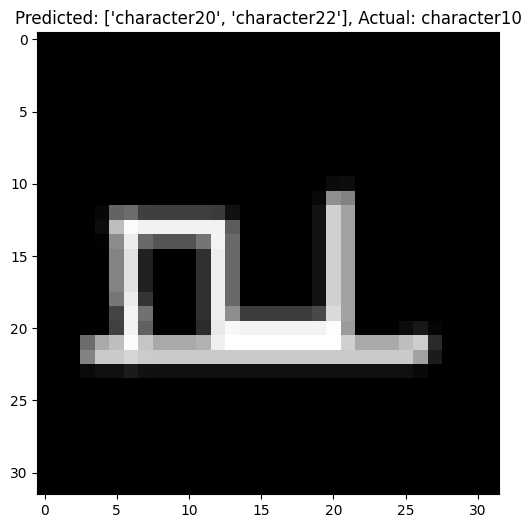

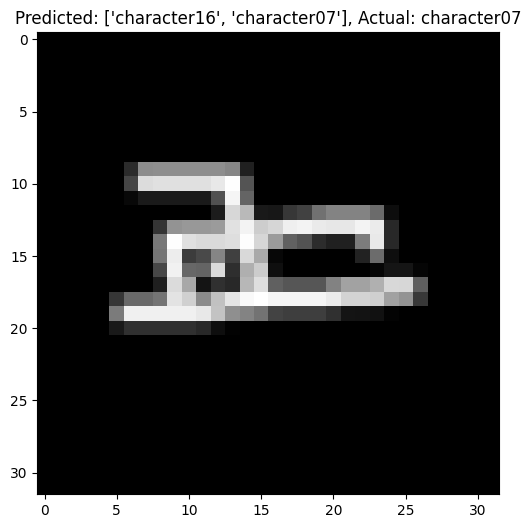

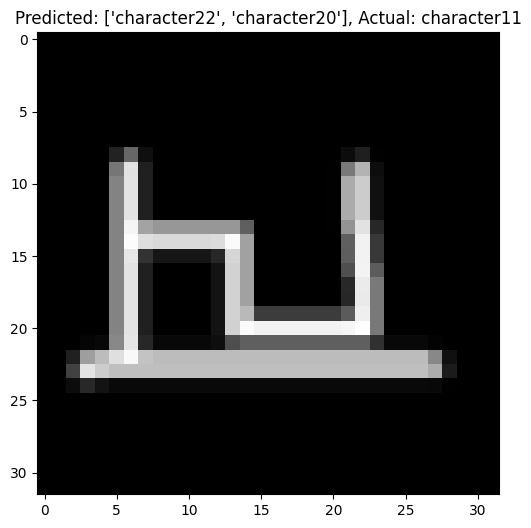

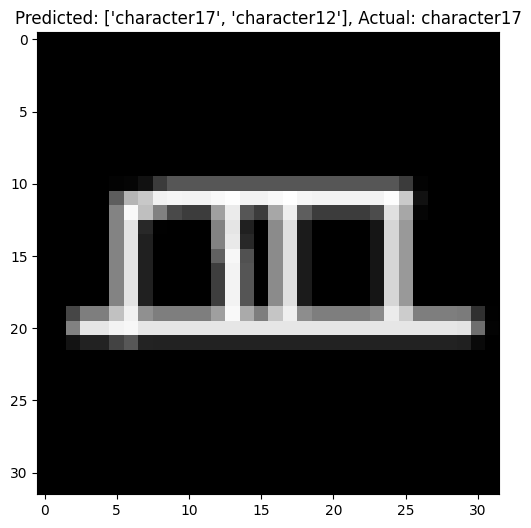

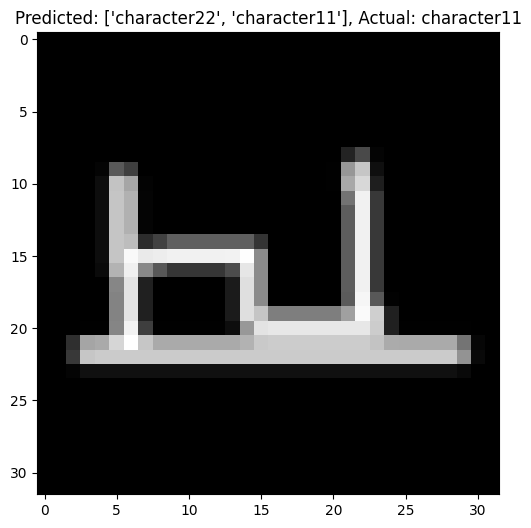

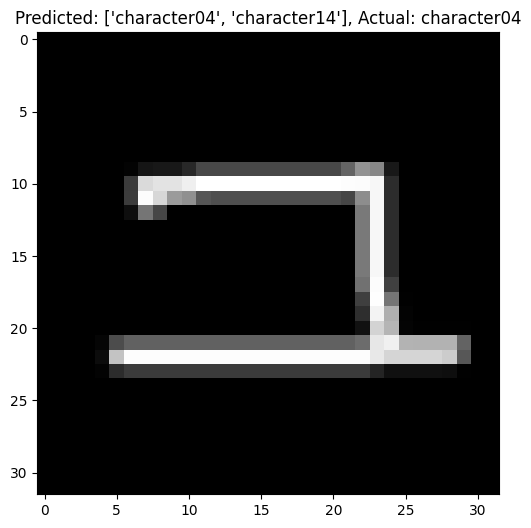

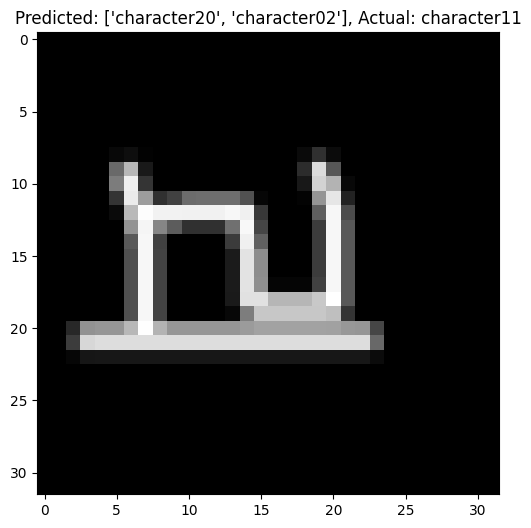

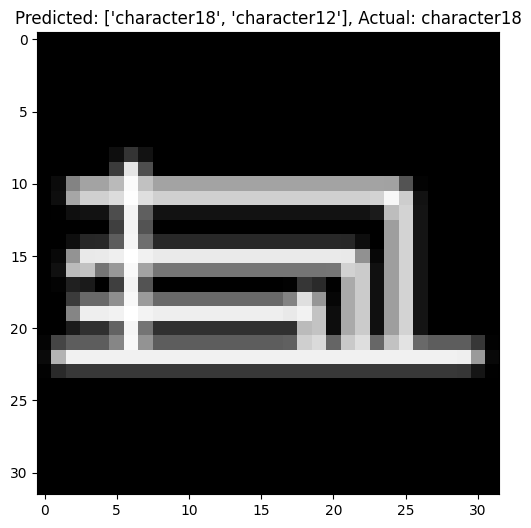

In [251]:
# Plot all the labelled images from a random alphabet in the test data
alphabets_test = list(data_dict_test['annotated_images'].keys())
alphabet_id = np.random.randint(0, len(alphabets_test))
alphabet = alphabets_test[alphabet_id]

alphabet_annotated = data_dict_test['annotated_images'][alphabet]
alphabet_annotated_labels = data_dict_test['annotated_images_labels'][alphabet]

num_images = len(alphabet_annotated)
print(f"Number of images in alphabet {alphabet}: {num_images}")

num_rows = num_images // 5 + (num_images % 5 > 0)  # This will round up to the nearest multiple of 5
num_cols = 5

plt.figure(figsize=(20, 8))
for i in range(num_images):
    plt.subplot(num_rows, num_cols, i+1)
    plt.imshow(alphabet_annotated[i].squeeze(0), cmap='gray')
    plt.title(alphabet_annotated_labels[i])
    plt.axis('off')


# Random indexes from the unseen images
random_idx = np.random.choice(len(data_dict_test['unseen_images'][alphabet]), 10)
K = 2
# Plot 10 unseen images from the same alphabet with their predicted labels
for i, unseen_image in enumerate(data_dict_test['unseen_images'][alphabet][random_idx]):

            # compute embedding for unseen image
            toPILImage = transforms.ToPILImage()
            unseen_image = toPILImage(unseen_image)
            unseen_image = preprocess(unseen_image)
            embedding_unseen = triplet_network.get_embedding(unseen_image.unsqueeze(0))
            
            # list of cosine similarities
            distances = []

            for j, annotated_image in enumerate(data_dict_test['annotated_images'][alphabet]):

                # Convert the images to PIL images
                annotated_image = toPILImage(annotated_image)
                annotated_image = preprocess(annotated_image)
                embedding_unnnotated = triplet_network.get_embedding(annotated_image.unsqueeze(0))

                distance = (embedding_unseen - embedding_unnnotated).pow(2).sum(1).sqrt()
                distances.append(distance.item())

            # Get the indices of the K smallest distances
            #print(f"distances: {distances}")
            most_similar_indices = np.argsort(distances)[:K]
            #print(f"most similar indices: {most_similar_indices}")
            # Get the corresponding labels
            most_similar_labels = [data_dict_test['annotated_images_labels'][alphabet][idx] for idx in most_similar_indices]
            #print(f"most similar labels: {most_similar_labels}")

            # Get the actual label of the unseen image
            actual_label = data_dict_test['unseen_images_labels'][alphabet][random_idx[i]]
            #print(f"actual label: {actual_label}")

            plt.figure(figsize=(15, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(unseen_image.squeeze(0), cmap='gray')
            plt.title(f"Predicted: {most_similar_labels}, Actual: {actual_label}")






### Evaluate Siamese Network

In [ ]:
# accuracy_8 = evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=8)
# accuracy_1 = evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=1)
# accuracy_2 = evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=2)
# accuracy_4 = evaluate_siamese_network(siamese_network, data_dict_test, preprocess, K=4)

Accuracy for alphabet Angelic: 0.4763157894736842
Accuracy for alphabet Atemayar_Qelisayer: 0.31781376518218624
Accuracy for alphabet Atlantean: 0.31983805668016196
Accuracy for alphabet Aurek-Besh: 0.3299595141700405
Accuracy for alphabet Avesta: 0.37044534412955465
Accuracy for alphabet Ge_ez: 0.340080971659919
Accuracy for alphabet Glagolitic: 0.23157894736842105
Accuracy for alphabet Gurmukhi: 0.23391812865497075
Accuracy for alphabet Kannada: 0.22721437740693196
Accuracy for alphabet Keble: 0.3441295546558704
Accuracy for alphabet Malayalam: 0.22172452407614782
Accuracy for alphabet Manipuri: 0.19210526315789472
Accuracy for alphabet Mongolian: 0.3175438596491228
Accuracy for alphabet Old_Church_Slavonic_(Cyrillic): 0.20701754385964913
Accuracy for alphabet Oriya: 0.13615560640732266
Accuracy for alphabet Sylheti: 0.33646616541353386
Accuracy for alphabet Syriac_(Serto): 0.3684210526315789
Accuracy for alphabet Tengwar: 0.33473684210526317
Accuracy for alphabet Tibetan: 0.22305764

In [ ]:
# accuracy_1

0.04704097116843703

In [ ]:
# accuracy_2

0.08417857998562416

In [ ]:
# accuracy_4

0.15230412906317387

In [ ]:
# accuracy_8

0.2733008545643319

# Task 2: rotation problem

In [ ]:
# load the test data for task 2:
# the structure of the test data of task 2 is exactly the same as for task 1,
# but now the images are rotated by an unknown angle between 0 and 360 degrees.
data_dict_test_task2 = load_data('test_data_task2.pkl')

In [ ]:
data_dict_test_task2.keys()

In [ ]:
# solution and evaluation of task 2:

# Task 3: Domain knowledge injection

In [ ]:
# load the test data for task 3:
# the structure of the data of task 3 is exactly the same as for task 1, but now our the loaded dictionary contains some additional keys.
# These additional keys will be explained in the cells below:

data_dict_test_task3 = load_data('test_data_task3.pkl')
print(data_dict_test_task3.keys())

In [ ]:
# The keys 'annotated_images', 'annotated_images_labels', 'unseen_images', 'unseen_images_labels' are the same as for task 1, and the structure of the data is exactly the same. 

# The key 'unseen_images_preceding_types' maps to the type of the preceding character in the sequence where the unseen image was observed, for each alphabet.
# The key 'character_to_type_mapping' maps to the mapping of each character to its type, for each alphabet.
# The key 'type_following_probs' maps to the probabilities of each character type being followed by another character type, for each alphabet.

In [ ]:
# examples:

alphabet = np.random.choice(list(data_dict_test_task3['unseen_images_preceding_types'].keys()))
print(f'Alphabet: {alphabet}')


preceding_character_types_alphabet = data_dict_test_task3["unseen_images_preceding_types"][alphabet]  # a list
print(f'Some character types that preceded unseen images from the {alphabet} alphabet: {np.random.choice(preceding_character_types_alphabet, size=5)}')
print(f'There are {len(preceding_character_types_alphabet)} preceding character types in the {alphabet} alphabet, and {len(data_dict_test_task3["unseen_images"][alphabet])} unseen images.')


character_to_type_mapping_alphabet = data_dict_test_task3["character_to_type_mapping"][alphabet]  
# this is a dict, with as keys the characters and as values the types
random_character = np.random.choice(list(character_to_type_mapping_alphabet.keys()))
print(f'Type of {random_character} from the {alphabet} alphabet: {character_to_type_mapping_alphabet[random_character]}')



type_following_probs_alphabet = data_dict_test_task3["type_following_probs"][alphabet]  # a dict of dicts
preceding_type = np.random.choice(list(type_following_probs_alphabet.keys()))
following_type = np.random.choice(list(type_following_probs_alphabet[preceding_type].keys()))
print(f'Probability of a character of type {following_type} following a character of type {preceding_type} in the {alphabet} alphabet: {type_following_probs_alphabet[preceding_type][following_type]}')
